<a href="https://colab.research.google.com/github/azhar1701/flood_model-cms/blob/main/flood_inundation_cms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script is setting up the working environment for geospatial analysis using **Google Earth Engine** in Google Colab. First, it imports the necessary Python libraries: `numpy` for math operations, `matplotlib` for plotting graphs, `ee` (Earth Engine API) and `geemap` for handling geospatial data, plus `json` for data formatting. It also connects your Colab session to **Google Drive** so you can save or load files. Then, it runs the authentication step (`ee.Authenticate()`) so you can access Earth Engine with your Google account, and initializes a specific Earth Engine project (`ee.Initialize(...)`). In simple terms: this code prepares Colab so you can process satellite data and make maps with Earth Engine and geospatial tools.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import ee, geemap
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Authenticate and Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='glossy-topic-425603-j8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This part of the code is about **opening and reading a GeoJSON file** (a common format for storing map boundaries or location data). The file is stored in your **Google Drive**, and since the Drive was already connected to Colab, the script points to its location (`adm_ciamis.geojson`). Using Python’s `open()` function, it loads the file, and then `json.load()` converts the GeoJSON text into a Python object that you can work with. In simple terms: this code takes a map file from your Google Drive and makes it ready for analysis inside your Python notebook.


In [2]:
# Baca file GeoJSON dari Google Drive (setelah mount drive)
adm_cms_path = '/content/drive/My Drive/Colab Notebooks/geojson/adm_ciamis.geojson'
with open(adm_cms_path, 'r') as f:
    geojson_data = json.load(f)

This code cleans and prepares the boundary data from the GeoJSON file so it can be used in Google Earth Engine. Sometimes GeoJSON coordinates have a third value (the **z-dimension**, like height), but Earth Engine only needs latitude and longitude. The `strip_z` function removes that extra value, keeping only the 2D coordinates. After that, the cleaned coordinates are turned into an Earth Engine object (`ee.Geometry.MultiPolygon`) called **ROI** (Region of Interest). Finally, it prints the object type to confirm it worked. In short: it takes your map boundary, cleans it up, and loads it into Earth Engine for further analysis.

In [3]:
# Buang dimensi z jika ada
def strip_z(coords):
    if isinstance(coords[0][0], list):
        # Recursively strip z from nested coordinate list
        return [strip_z(c) for c in coords]
    else:
        return [[c[0], c[1]] for c in coords]  # Drop z
coordinates = geojson_data['features'][0]['geometry']['coordinates']
coordinates_2d = strip_z(coordinates)

# Memuat geojson dan memanggil objek di earth engine
ROI = ee.Geometry.MultiPolygon(coordinates_2d)
print("Tipe objek Earth Engine:", ROI.getInfo())

Tipe objek Earth Engine: {'type': 'Polygon', 'coordinates': [[[108.26918540900004, -7.318761384999959], [108.26964658300005, -7.318697207999946], [108.26969604000004, -7.318723458999955], [108.26971440300008, -7.318733205999933], [108.26975952400005, -7.318757154999957], [108.26993936200006, -7.318852609999965], [108.27016941200009, -7.319106975999944], [108.27071716000006, -7.319712618999972], [108.27072359400006, -7.319719732999943], [108.27072760600004, -7.319723474999932], [108.27088305600006, -7.319868429999929], [108.27120084400008, -7.320164766999937], [108.27121603700004, -7.320231087999957], [108.27138900200003, -7.320986101999949], [108.27138942700009, -7.320987957999932], [108.27142293200006, -7.321423987999935], [108.27144344200008, -7.321690910999962], [108.27147311700008, -7.321768125999938], [108.27170820300006, -7.322379823999938], [108.27180976900007, -7.32264410099998], [108.27205472000009, -7.323192344999939], [108.27214377300004, -7.32339166099996], [108.27222425000

This code brings in **Sentinel-1A satellite radar images** from Google Earth Engine and filters them so we only get the type of data useful for flood analysis. It chooses images with the **VH polarization** (good for detecting water), the **IW mode** (standard radar mode), and only those captured when the satellite was moving **downward (descending orbit)** over the area. Then it splits the data into two time ranges: before the flood (April 1–15, 2025) and after the flood (April 16–30, 2025). Finally, it prints how many images were found for each period. In short: it collects “before” and “after” radar images over the study area to compare flood conditions.

In [4]:
# Impor Citra Sentinel-1A
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VH'))\
    .filter(ee.Filter.eq('instrumentMode','IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass','DESCENDING'))\
    .filterBounds(ROI)\

# Memilih Rentang Waktu Pra dan Pasca Banjir
pra_banjir = S1.filter(ee.Filter.date('2025-01-01','2025-01-31'))
pasca_banjir = S1.filter(ee.Filter.date('2025-02-01','2025-02-28'))

print('Dataset S-1 Pra Banjir :', pra_banjir.size().getInfo())
print('Dataset S-1 Pasca Banjir :', pasca_banjir.size().getInfo())

Dataset S-1 Pra Banjir : 6
Dataset S-1 Pasca Banjir : 4


This function adds **filters (masks)** to clean up the satellite image so the flood detection is more accurate. First, it uses **SRTM elevation data** to calculate the slope and keeps only areas with gentle slopes (less than 10°) to avoid errors caused by radar shadows on steep terrain. Then, it uses the **JRC Global Surface Water dataset** to identify places that are almost always water (permanent water bodies, like lakes or big rivers) and removes them, since they aren’t floods. In simple terms: this code removes steep areas and permanent water so the analysis focuses only on new or unusual flooding.

In [5]:
# Masking lereng dan tubuh air permanen
def apply_indonesia_masks(img_db: ee.Image, ROI, slope_max_deg=10) -> ee.Image:

    # Mask lereng (kurangi layover/shadow)
    srtm = ee.Image('USGS/SRTMGL1_003')
    slope = ee.Terrain.slope(srtm)
    slope_mask = slope.lt(slope_max_deg) # Define slope_mask
    buffer_edge = ROI.buffer(-60)  # hindari artefak tepi
    img_db = img_db.updateMask(slope_mask).clip(buffer_edge)

    # JRC GSW: air permanen
    gsw = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')
    perm = gsw.gte(90)
    seasonal = gsw.gte(50).And(gsw.lt(90))
    non_flood = perm.Or(seasonal) # Define non_flood
    # Masking: buang perm, tapi tandai seasonal untuk QC
    return img_db.updateMask(non_flood.Not())

This code prepares the **before and after flood images** for analysis. It first merges and clips the Sentinel-1 radar images (VH band) to match the study area (ROI). Then it cleans them by reducing **speckle noise** (the grainy radar effect) using a smoothing filter called `focalMedian`. After that, it calculates the difference between the post-flood and pre-flood images, so areas with big changes in radar signal can show where flooding may have happened. In short: it cleans the satellite images and then compares “before” vs “after” to highlight possible flood zones.

In [6]:
# Clip data citra Pra dan Pasca Banjir
pra_banjir_img = pra_banjir.select('VH').median().clip(ROI)
pasca_banjir_img = pasca_banjir.select('VH').median().clip(ROI)

# Konversi ke skala linear untuk filtering lalu kembali ke dB
def to_linear(image):
    return ee.Image.constant(10).pow(image.divide(10))

def to_db(image):
    safe_image = image.max(ee.Image.constant(1e-6))
    return safe_image.log10().multiply(10)

# Filter speckle noise pakai Lee Speckle
def lee_filter(img, radius=2):
    # versi ringkas (aproksimasi); bisa diganti dengan implementasi Refined Lee yang lengkap
    mean = img.reduceNeighborhood(ee.Reducer.mean(), ee.Kernel.square(radius))
    var = img.reduceNeighborhood(ee.Reducer.variance(), ee.Kernel.square(radius))
    mean = mean.max(ee.Image.constant(1e-6))
    ci = var.sqrt().divide(mean).max(ee.Image.constant(1e-3))  # coefficient of variation
    w = var.divide(var.add(ci.pow(-2).multiply(mean.pow(2))))
    return mean.add(w.multiply(img.subtract(mean)))

pra_banjir_linear = to_linear(pra_banjir_img)
pasca_banjir_linear = to_linear(pasca_banjir_img)

pra_banjir_img_filtered = lee_filter(pra_banjir_linear)
pasca_banjir_img_filtered = lee_filter(pasca_banjir_linear)

pra_banjir_img_filtered_db = to_db(pra_banjir_img_filtered)
pasca_banjir_img_filtered_db = to_db(pasca_banjir_img_filtered)

# Hitung perbedaan backscatter antar periode (dB)
diff = pasca_banjir_img_filtered_db.subtract(pra_banjir_img_filtered_db)


This code creates a **histogram** (graph of pixel values) from the radar image difference to see how the backscatter changes before and after the flood. It then uses the **Otsu method**, a statistical technique, to automatically find the best threshold that separates two groups of pixels: likely flooded and non-flooded areas. The histogram is plotted so you can visually see the distribution, and the Otsu function calculates the exact threshold value. In simple terms: this step finds the “cut-off point” in the image data that helps distinguish flooded zones from dry land.

Threshold Otsu: 0.5355203313185491


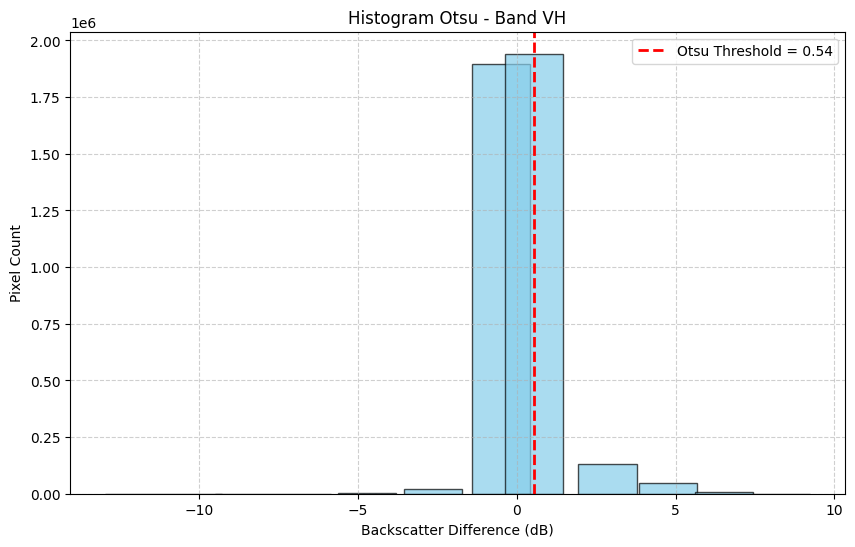

In [7]:
# Hitung histogram menggunakan reduceRegion
histogram = diff.select('VH_mean').reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=255, minBucketWidth=2),
    geometry=ROI,
    scale=20,
    bestEffort=True,
    maxPixels=1e8
).getInfo()

# Ekstrak histogram dan bucketMeans dari hasil
counts = histogram['VH_mean']['histogram']
means = histogram['VH_mean']['bucketMeans']

# Fungsi Otsu Threshold (Python)
def otsu_threshold(counts, means):
    total = np.sum(counts)
    sum_total = np.sum(means * counts)
    sumB = 0
    wB = 0
    max_var = 0
    threshold = means[0]

    for i in range(len(counts)):
        wB += counts[i]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += means[i] * counts[i]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        var_between = wB * wF * (mB - mF) ** 2
        if var_between > max_var:
            max_var = var_between
            threshold = means[i]
    return threshold

# Hitung threshold Otsu
threshold = otsu_threshold(np.array(counts), np.array(means))
print(f'Threshold Otsu: {threshold}')

# Plot histogram dengan garis threshold
plt.figure(figsize=(10,6))
plt.bar(means, counts, width=(means[1]-means[0]),
        color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2,
            label=f'Otsu Threshold = {threshold:.2f}')
plt.title('Histogram Otsu - Band VH')
plt.xlabel('Backscatter Difference (dB)')
plt.ylabel('Pixel Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This step creates the actual **flood map**. First, it makes a mask of flooded areas by marking all pixels with values higher than the Otsu threshold (meaning they likely changed due to flooding). Then, it applies the earlier filters to remove steep slopes and permanent water bodies, leaving only the areas that are truly potential flood zones. In short: this code turns the image differences into a clean flood map focused on realistic flood-affected areas.

In [8]:
# Buat mask banjir dengan threshold Otsu
kernel = ee.Kernel.square(2)  # 5x5 piksel
local_mean = diff.reduceNeighborhood(ee.Reducer.mean(), kernel)
local_std  = diff.reduceNeighborhood(ee.Reducer.stdDev(), kernel)
zscore = diff.subtract(local_mean).divide(local_std.add(1e-3))
flood_mask = zscore.lt(-1.0)  # banjir = jauh lebih gelap dari sekitar

# Terapkan slope & permanen water mask
final_mask = apply_indonesia_masks(flood_mask, ROI)

# Sanity check
s2_collection_2025 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(ROI).filterDate('2025-01-01','2025-12-31')
      .filter('CLOUDY_PIXEL_PERCENTAGE < 20'))

s2_dates_2025 = ee.List(
    s2_collection_2025.aggregate_array('system:time_start')
).map(lambda t: ee.Date(t).format('YYYY-MM-dd'))
print('Sentinel-2 dates (2025, cloud <20%):', s2_dates_2025.getInfo())

s2_collection = s2_collection_2025.filterDate('2025-01-01','2025-03-31')
print('Sentinel-2 collection size (Jan-Mar 2025):', s2_collection.size().getInfo())

s2 = s2_collection.median().clip(ROI)

print('Sentinel-2 image bands:', s2.bandNames().getInfo())

ndwi = s2.normalizedDifference(['B3','B8'])
agreement = final_mask.And(ndwi.gt(0.2))


Sentinel-2 collection size: 3
Sentinel-2 image bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


This code calculates the **total flooded area** inside the study region. It first converts each pixel’s size into **hectares** (1 ha = 10,000 m²), then keeps only the pixels marked as flooded in the final mask. After that, it adds up all those pixels to get the total flood extent in hectares and prints the result. In simple terms: this step measures how big the flood-affected area is.

In [9]:
# Luas (ha)
area_ha_img = ee.Image.pixelArea().divide(10000).updateMask(agreement)
area_stats = area_ha_img.reduceRegion(
    reducer=ee.Reducer.sum(), geometry=ROI, scale=10, bestEffort=True, tileScale=4
)
print('Luas genangan (ha):', area_stats.get('area').getInfo())

Luas genangan (ha): 4.674802450561523


This code sets up the **map display** so you can visually explore the results. It defines how the images should look (color ranges and palettes), creates an interactive map with a satellite basemap, and zooms into the study area. Then it adds several layers: the region boundary (ROI), the pre- and post-flood radar images, the difference between them, and finally the flood mask highlighted in blue. In simple terms: this step builds an interactive map where you can see and compare before/after images and clearly view the detected flood areas.

In [10]:
# Sesuaikan visualisasi parameter
vis_params = {'min': -25, 'max': -5, 'palette': ['black','gray','white']}

# Tuning Map Container
Map = geemap.Map(basemap = 'HYBRID', zoom=11)
Map.centerObject(ROI, 10) # Sesuaikan level zoom jika perlu

# Tambahkan layer pada Map Container
Map.addLayer(ROI, {}, 'ROI')
Map.addLayer(pra_banjir_img, vis_params, 'Pra Banjir')
Map.addLayer(pasca_banjir_img, vis_params, 'Pasca Banjir')
Map.addLayer(diff, {'min': -5, 'max': 5, 'palette': ['red', 'white', 'blue']}, 'Backscatter Difference')
Map.addLayer(agreement, {'palette': ['0000FF']}, 'Flood Mask (Otsu Threshold + Sanity Check (S2 NDWI))')

# Tampilkan Map Container
Map


Map(center=[-7.290228153090681, 108.42859527036555], controls=(WidgetControl(options=['position', 'transparent…